<a href="https://colab.research.google.com/github/Karlobyo/dotfiles/blob/master/CompElec_Model_TESTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
#Importing Libraries
#import fluidsynth
import librosa
from librosa import beat
import pretty_midi
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import os
from google.colab import files
import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
path = "/content/drive/MyDrive/MODELS/"


In [46]:
model = tensorflow.keras.models.load_model(path)

In [47]:
# enables muender images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# converts midi files to wav files in order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

installing lilypond...
installing fluidsynth...
done!


In [48]:
filepath = "/content/drive/MyDrive/classical piano midis dataset/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

print("First fifty values in the Corpus:", Corpus[:50])


#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi


Total notes in all the Chopin midis in the dataset: 63429
First fifty values in the Corpus: ['C2', 'C3', 'G3', 'C4', 'E4', 'C4', 'G4', 'C5', 'E5', 'C5', 'G5', 'C6', 'E6', 'C6', 'G6', 'C7', 'E7', 'C7', 'G6', 'C6', 'E6', 'C6', 'G5', 'C5', 'E5', 'C5', 'G4', 'C4', 'E4', 'C4', 'G3', 'C3', '5', 'C3', 'A3', 'C4', 'F4', 'C4', 'A4', 'C5', 'F5', 'C5', 'A5', 'C6', 'F6', 'C6', 'A6', 'C7', 'E7', '6']


In [ ]:
Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

type(Melody_Snippet)

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(str(filename) + '.wav'))

play(Melody_Snippet)

Corpus

Mel_1 = Melody_Snippet

play(Mel_1)


Total unique notes in the Corpus: 317
Average recurrenc for a note in Corpus: 200.09148264984228
Most frequent note in Corpus appeared: 1869 times
Least frequent note in Corpus appeared: 1 time


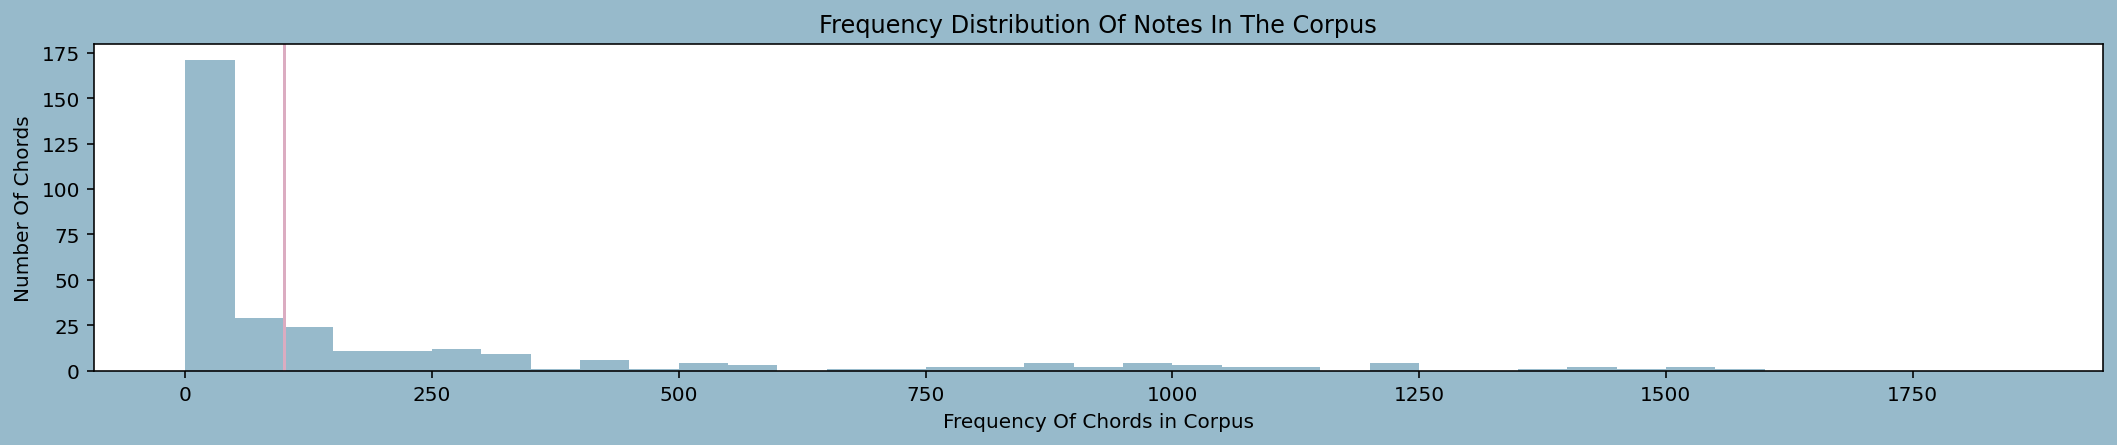

In [50]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()


In [51]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))


#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))


Total number of notes that occur less than 100 times: 200
Length of Corpus after elemination the rare notes: 59853


In [52]:
# Storing all the unique characters present in my corpus to build a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of characters: 59853
Number of unique characters: 228
Total number of sequences in the Corpus: 59813


In [53]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form of a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

In [89]:
music_path = "/content/drive/MyDrive/Melody_Generated.mid"

y_ex, sr = librosa.load(Melody_midi, duration=30)
onset_env = librosa.onset.onset_strength(y_ex=y_ex, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
tempo

NameError: ignored

In [ ]:
#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)


In [85]:
type(Melody)

music21.stream.Stream

In [56]:
#To save the generated melody
melody1 = Melody.write('midi','Melody_Generated.mid')

In [84]:
melody1

'Melody_Generated.mid'

In [77]:
 def midi_to_wav_player(midi_file):
  !fluidsynth -ni font.sf2 $midi_file -F $midi_file\.wav -r 16000 > /dev/null
  display(Audio(str(midi_file) + '.wav'))

In [78]:
example_wav = midi_to_wav_player(melody1)

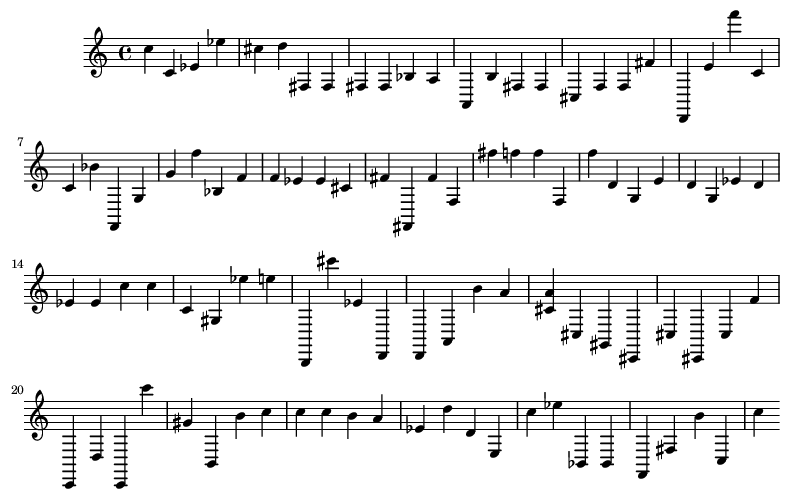

In [59]:
Music_notes, Melody_2 = Malody_Generator(100)
show(Melody_2)

In [60]:
def music_generator(Note_count):
  Music_notes, Melody = Malody_Generator(Note_count)
  mel = Melody.write('midi','Music_Generated.mid')
  !fluidsynth -ni font.sf2 $mel -F $mel\.wav -r 16000 > /dev/null
  display(Audio(str(mel) + '.wav'))
  show(Melody)



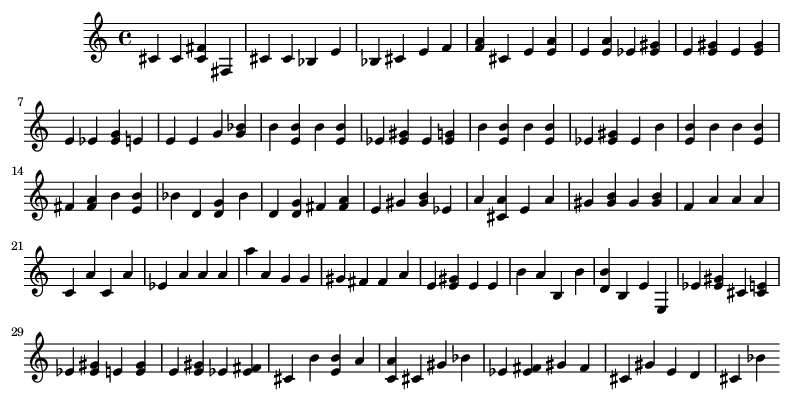

In [75]:
new_music = music_generator(100)

In [63]:
import librosa

In [64]:
from librosa import beat

In [74]:
melody1

'Melody_Generated.mid'

TypeError: ignored